<a href="https://colab.research.google.com/github/MajiroZ/for_git_study/blob/master/natural_language_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2024-12-19 07:46:54--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  9.58MB/s    in 7.9s    

2024-12-19 07:47:02 (10.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an a

In [2]:
from sklearn.datasets import load_files

train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target

test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [3]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


### BoW

In [4]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()

# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names_out())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


##【問題1】BoWのスクラッチ実装

In [7]:
import re

def build_bow(sentences, n_gram_range=(1, 2)):
    vocab = set()
    for sentence in sentences:
        words = re.findall(r'\b\w+\b', sentence.lower())  # 単語に分割（小文字化）
        for i in range(len(words)):
            for n in range(n_gram_range[0], min(n_gram_range[1] + 1, len(words) - i + 1)):
                vocab.add(" ".join(words[i : i + n])) # n-gram を作成して追加

    vocab = sorted(list(vocab))
    bow_matrix = []

    for sentence in sentences:
      words = re.findall(r'\b\w+\b', sentence.lower())
      bow = {}
      for word in vocab:
        bow[word] = 0

      for i in range(len(words)):
          for n in range(n_gram_range[0], min(n_gram_range[1] + 1, len(words) - i + 1)):
            ngram = " ".join(words[i : i + n])
            if ngram in vocab:
                bow[ngram] +=1

      bow_matrix.append(list(bow.values()))
    return vocab, bow_matrix


sentences = [
    "This movie is SOOOO funny!!!",
    "What a movie! I never",
    "best movie ever!!!!! this movie"
]

vocab, bow = build_bow(sentences)

import pandas as pd
df = pd.DataFrame(bow, columns=vocab)
df

,a,a movie,best,best movie,ever,ever this,funny,i,i never,is,...,movie ever,movie i,movie is,never,soooo,soooo funny,this,this movie,what,what a
0,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,1,1,1,1,0,0
1,1,1,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,1
2,0,0,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0


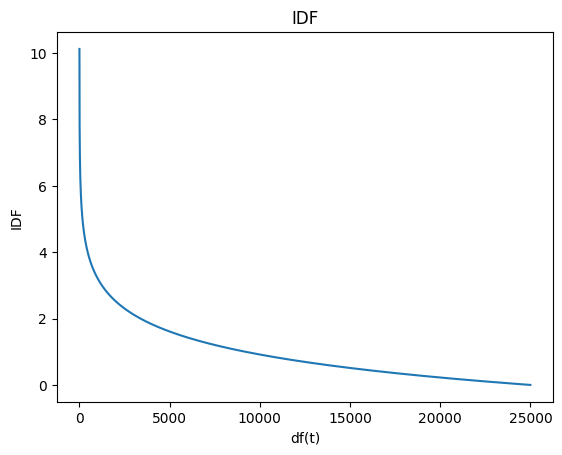

In [8]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

In [10]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names_out())
display(df)

,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


In [11]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names_out())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


##【問題2】TF-IDFの計算

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000, token_pattern=r'\b\w+\b')
tfidf_train = vectorizer.fit_transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(tfidf_train.shape)
tfidf_test.shape

(25000, 5000)


(25000, 5000)

##【問題3】

In [15]:
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルのインスタンスを作成
model = LogisticRegression()

# モデルを学習
model.fit(tfidf_train, y_train)

# テストデータで推定
y_pred = model.predict(tfidf_test)

# 評価指標（例：正解率）を表示
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.88344


In [16]:
from sklearn.datasets import load_files
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Define parameter combinations for experiment
vocab_sizes = [1000, 5000, 10000]
stop_word_options = [None, stopwords.words('english')]
n_gram_ranges = [(1,1), (1,2)]

results = []

for vocab_size in vocab_sizes:
    for stop_words in stop_word_options:
        for n_gram_range in n_gram_ranges:
            print(f"Training with vocab_size={vocab_size}, stop_words={stop_words}, n_gram_range={n_gram_range}")
            vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=vocab_size, token_pattern=r'\b\w+\b', ngram_range=n_gram_range)
            tfidf_train = vectorizer.fit_transform(x_train)
            tfidf_test = vectorizer.transform(x_test)

            model = LogisticRegression()
            model.fit(tfidf_train, y_train)
            y_pred = model.predict(tfidf_test)
            accuracy = accuracy_score(y_test, y_pred)

            results.append({
                'vocab_size': vocab_size,
                'stop_words': stop_words,
                'n_gram_range': n_gram_range,
                'accuracy': accuracy
            })

# Display results in a DataFrame
results_df = pd.DataFrame(results)
results_df

Training with vocab_size=1000, stop_words=None, n_gram_range=(1, 1)
Training with vocab_size=1000, stop_words=None, n_gram_range=(1, 2)
Training with vocab_size=1000, stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here'

,vocab_size,stop_words,n_gram_range,accuracy
0,1000,None,"(1, 1)",0.86704
1,1000,None,"(1, 2)",0.85696
2,1000,"[i, me, my, myself, we, our, ours, ourselves, ...","(1, 1)",0.86504
3,1000,"[i, me, my, myself, we, our, ours, ourselves, ...","(1, 2)",0.86568
4,5000,None,"(1, 1)",0.88656
5,5000,None,"(1, 2)",0.89020
6,5000,"[i, me, my, myself, we, our, ours, ourselves, ...","(1, 1)",0.88344
7,5000,"[i, me, my, myself, we, our, ours, ourselves, ...","(1, 2)",0.88848
8,10000,None,"(1, 1)",0.88576
9,10000,None,"(1, 2)",0.89572


語彙数は5,000以上あった方が精度が高く、n-gramは1-gramと2-gramを組み合わせてBoWを行うと精度がまた上がることが分かった。

##【問題4】TF-IDFのスクラッチ実装

In [19]:
import re
import math

def tfidf_standard(sentences):
    # 1.単語の出現回数をカウント
    vocab = set()
    tf_dict = {}
    for i, sentence in enumerate(sentences):
        words = re.findall(r'\b\w+\b', sentence.lower())
        tf_dict[i] = {}
        for word in words:
            vocab.add(word)
            tf_dict[i][word] = tf_dict[i].get(word, 0) + 1

    vocab = sorted(list(vocab))

    # 2.TFの計算
    tf_matrix = []
    for i in range(len(sentences)):
      tf_row = []
      for word in vocab:
        tf_row.append(tf_dict[i].get(word, 0))
      tf_matrix.append(tf_row)

    # 3.IDFの計算
    idf_vector = []
    for word in vocab:
        df = 0
        for i in range(len(sentences)):
          if word in tf_dict[i]:
            df += 1
        idf_vector.append(math.log(len(sentences) / df))

    # 4.TF-IDFの計算
    tfidf_matrix = []
    for i in range(len(sentences)):
      tfidf_row = []
      for j in range(len(vocab)):
        tfidf_row.append(tf_matrix[i][j] * idf_vector[j])
      tfidf_matrix.append(tfidf_row)

    return vocab, tfidf_matrix


def tfidf_sklearn(sentences):

    # 1.単語の出現回数をカウント
    vocab = set()
    tf_dict = {}
    for i, sentence in enumerate(sentences):
        words = re.findall(r'\b\w+\b', sentence.lower())
        tf_dict[i] = {}
        for word in words:
            vocab.add(word)
            tf_dict[i][word] = tf_dict[i].get(word, 0) + 1
    vocab = sorted(list(vocab))

    # 2.TFの計算
    tf_matrix = []
    for i in range(len(sentences)):
      tf_row = []
      for word in vocab:
          tf_row.append(tf_dict[i].get(word,0))
      tf_matrix.append(tf_row)

    # 3.IDFの計算
    idf_vector = []
    for word in vocab:
      df = 0
      for i in range(len(sentences)):
        if word in tf_dict[i]:
            df += 1
      idf_vector.append(1 + math.log((len(sentences) + 1) / (df + 1)))

    # 4.TF-IDFの計算
    tfidf_matrix = []
    for i in range(len(sentences)):
      tfidf_row = []
      for j in range(len(vocab)):
        tfidf_row.append(tf_matrix[i][j] * idf_vector[j])
      tfidf_matrix.append(tfidf_row)

    return vocab, tfidf_matrix

sentences = [
    "This movie is SOOOO funny!!!",
    "What a movie! I never",
    "best movie ever!!!!! this movie"
]

vocab, tfidf = tfidf_standard(sentences)
print("Standard TF-IDF:")
import pandas as pd
df = pd.DataFrame(tfidf, columns=vocab)
print(df)

vocab, tfidf = tfidf_sklearn(sentences)
print("\nsklearn-like TF-IDF:")
df = pd.DataFrame(tfidf, columns=vocab)
df

Standard TF-IDF:
          a      best      ever     funny         i        is  movie  \
0  0.000000  0.000000  0.000000  1.098612  0.000000  1.098612    0.0   
1  1.098612  0.000000  0.000000  0.000000  1.098612  0.000000    0.0   
2  0.000000  1.098612  1.098612  0.000000  0.000000  0.000000    0.0   

      never     soooo      this      what  
0  0.000000  1.098612  0.405465  0.000000  
1  1.098612  0.000000  0.000000  1.098612  
2  0.000000  0.000000  0.405465  0.000000  

sklearn-like TF-IDF:


,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0.000000,0.000000,0.000000,1.693147,0.000000,1.693147,1.0,0.000000,1.693147,1.287682,0.000000
1,1.693147,0.000000,0.000000,0.000000,1.693147,0.000000,1.0,1.693147,0.000000,0.000000,1.693147
2,0.000000,1.693147,1.693147,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,1.287682,0.000000


全体的に、scikit-learnを使用した方が各値が大きく出る傾向にある。

In [21]:
!pip install --upgrade gensim

In [24]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, vector_size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs) # 学習

print("語彙の一覧 : {}".format(model.wv.key_to_index.keys()))

for vocab in model.wv.key_to_index.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['very', 'bad', 'good', 'is', 'this', 'a', 'film', 'movie'])
veryのベクトル : 
[-0.00536227  0.00236431  0.0510335   0.09009273 -0.0930295  -0.07116809
  0.06458873  0.08972988 -0.05015428 -0.03763372]
badのベクトル : 
[ 0.07380505 -0.01533471 -0.04536613  0.06554051 -0.0486016  -0.01816018
  0.0287658   0.00991874 -0.08285215 -0.09448818]
goodのベクトル : 
[ 0.07311766  0.05070262  0.06757693  0.00762866  0.06350891 -0.03405366
 -0.00946401  0.05768573 -0.07521638 -0.03936104]
isのベクトル : 
[-0.07511629 -0.00930048  0.09538178 -0.07319212 -0.02333783 -0.01937753
  0.08077487 -0.05930933  0.00045163 -0.04753764]
thisのベクトル : 
[-0.0960355   0.05007293 -0.08759586 -0.04391825 -0.000351   -0.00296181
 -0.0766124   0.09614743  0.04982058  0.09233143]
aのベクトル : 
[-0.08157917  0.04495798 -0.04137076  0.00824536  0.08498619 -0.04462177
  0.045175   -0.0678696  -0.03548489  0.09398508]
filmのベクトル : 
[-0.01577672  0.00321376 -0.04140681 -0.07682785 -0.01508027  0.02469826
 -0.00888038  0.05533731 

In [25]:
model.wv.most_similar(positive="good", topn=3)

[('movie', 0.42731544375419617),
 ('bad', 0.32937225699424744),
 ('very', 0.3004249036312103)]

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


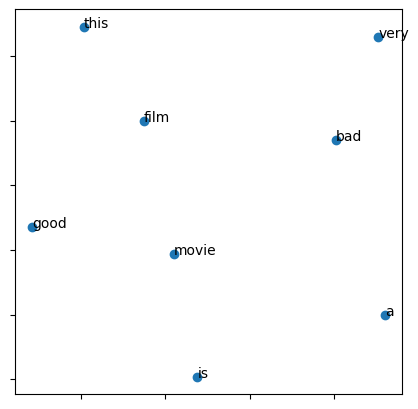

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocabs = model.wv.key_to_index.keys()

tsne_model = TSNE(perplexity=5, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model.wv[vocabs])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

##【問題5】コーパスの前処理

In [29]:
import re

def preprocess(text):
    # 特殊文字とURLの除去
    text = re.sub(r'[^\w\s]', '', text)  # 特殊文字を除去
    text = re.sub(r'http\S+', '', text)  # URLを除去

    # 大文字小文字の統一
    text = text.lower()

    # 単語に分割
    words = text.split()

    return words

# x_train の前処理
preprocessed_x_train = [preprocess(text) for text in x_train]

# 確認用 (最初のレビューの最初の10単語を表示)
print(preprocessed_x_train[0][:10])

['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 'rethink', 'why', 'two']


##【問題6】Word2Vecの学習

In [30]:
# Word2Vecモデルの学習
model = Word2Vec(sentences=preprocessed_x_train, vector_size=100, window=5, min_count=5, workers=4)

# モデルの保存
model.save("word2vec.model")

# モデルの読み込み
model = Word2Vec.load("word2vec.model")

# 学習済みモデルの確認
print("語彙数:", len(model.wv))
print("ベクトル次元数:", model.vector_size)

# 類似度の高い単語の表示
print(model.wv.most_similar("good", topn=10))

語彙数: 32057
ベクトル次元数: 100
[('bad', 0.7442300319671631), ('decent', 0.7398573756217957), ('great', 0.7301491498947144), ('cool', 0.6645030379295349), ('nice', 0.6504058241844177), ('fine', 0.6502115726470947), ('funny', 0.617178201675415), ('okay', 0.6053385734558105), ('interesting', 0.5893105268478394), ('ok', 0.5890000462532043)]


##【問題7】ベクトルの可視化

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


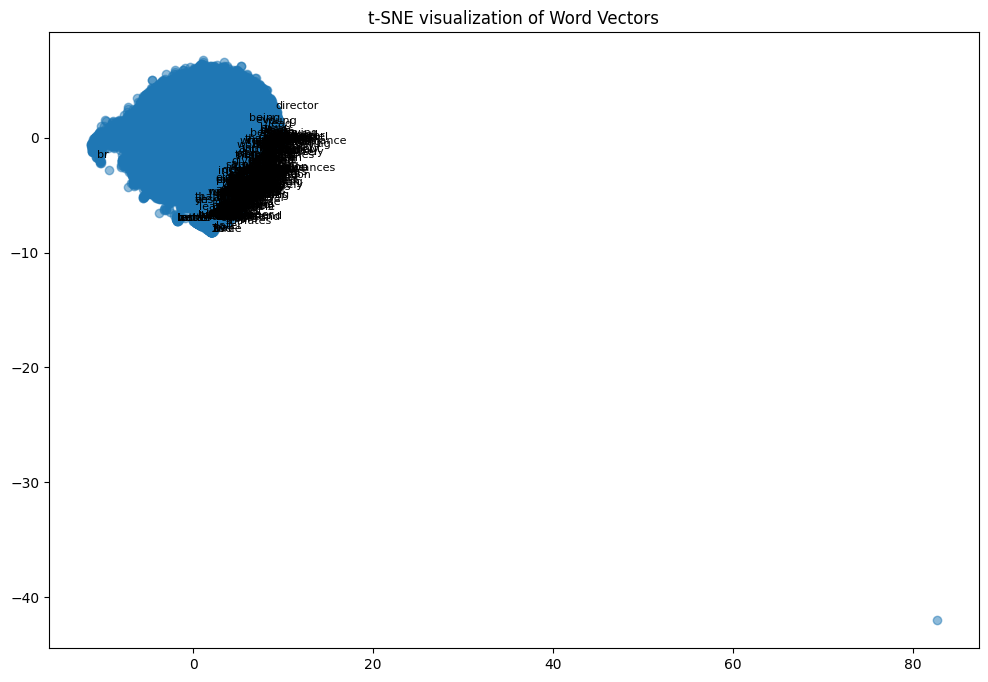

In [31]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Get vocabulary and vectors
vocabs = list(model.wv.index_to_key)  # Use index_to_key to get all words
vectors = model.wv[vocabs]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Adjust perplexity and n_iter if needed
vectors_2d = tsne.fit_transform(vectors)

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.5)

# Annotate some of the points (limit to a subset for readability)
for i, word in enumerate(vocabs[:500]): # Adjust the slice to show fewer words
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), size=8)

plt.title('t-SNE visualization of Word Vectors')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


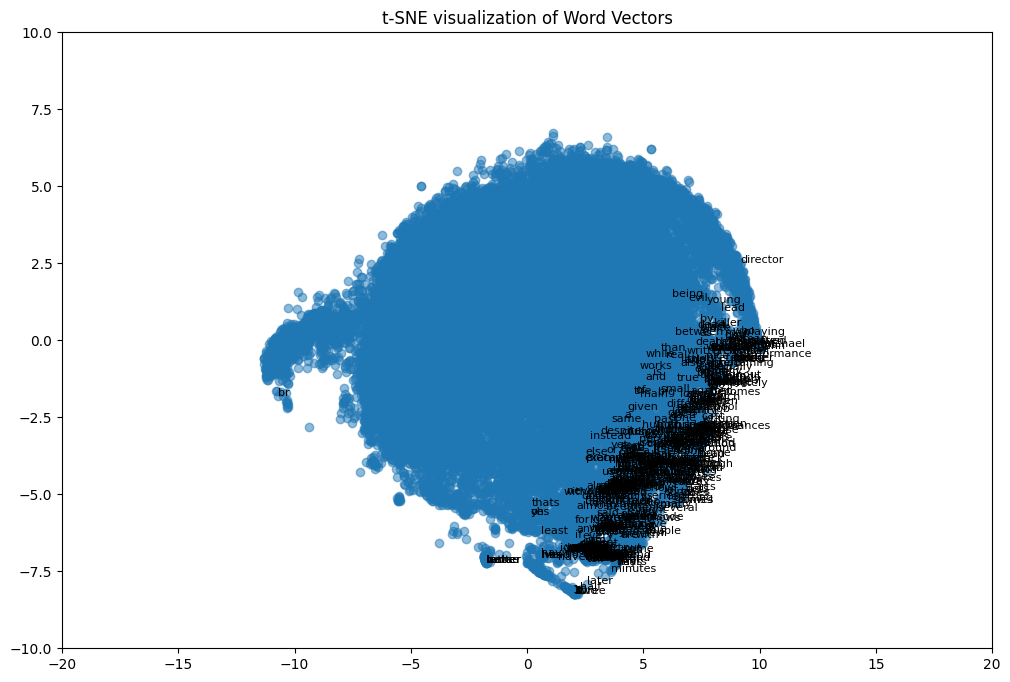

In [33]:
# Get vocabulary and vectors
vocabs = list(model.wv.index_to_key)  # Use index_to_key to get all words
vectors = model.wv[vocabs]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Adjust perplexity and n_iter if needed
vectors_2d = tsne.fit_transform(vectors)

# Plot the results
plt.figure(figsize=(12, 8))
plt.xlim(-20,20) #x軸を-100から100まで
plt.ylim(-10,10) #y軸を-50から50まで
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.5)

# Annotate some of the points (limit to a subset for readability)
for i, word in enumerate(vocabs[:500]): # Adjust the slice to show fewer words
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), size=8)

plt.title('t-SNE visualization of Word Vectors')
plt.show()

##【問題8】Word2Vecを用いた映画レビューの分類

In [34]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# レビューをベクトルに変換する関数
def document_vector(words, model, size):
    vectors = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])

    if vectors:
        return np.mean(vectors, axis=0)  # 平均ベクトルを返す
    else:
        return np.zeros(size)  # 単語が一つもvocabularyに存在しない場合はゼロベクトル

# 学習データとテストデータをベクトル化
train_vectors = np.array([document_vector(doc, model, model.vector_size) for doc in preprocessed_x_train])
test_vectors = np.array([document_vector(preprocess(text), model, model.vector_size) for text in x_test])


# ロジスティック回帰モデルの学習
clf = LogisticRegression(max_iter=1000)  # 収束しない場合、max_iterを増やす
clf.fit(train_vectors, y_train)

# テストデータでの予測
y_pred = clf.predict(test_vectors)

# 精度の評価
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Word2Vec: {accuracy}")

Accuracy with Word2Vec: 0.8332
